In [ ]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf
import PIL
import skimage
import albumentations

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, UpSampling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


print('슝=3')
print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)


# Step 1. KITTI 데이터셋 수집과 구축
- 다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축
- 메모리 사용량이 많으므로 배치 사이즈를 적절히 줄이기

In [ ]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                        HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                        RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                            ),
                        Resize(              # 입력이미지를 224X224로 resize
                            width=224,
                            height=224
                            )
                        ])
        return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                        Resize(
                            width=224,
                            height=224
                            )
                        ])

In [ ]:
!pip install albumentations

from albumentations import Compose, Resize

aug = Compose([Resize(224, 224)])
image = {"image": np.zeros((300, 300, 3), dtype=np.uint8)}
aug(**image)  # 정상 작동하면 오류 없어야 함


In [ ]:
from albumentations import Compose, Resize

def build_augmentation(is_train=True):
    if is_train:
        return Compose([
            Resize(224, 224)
        ])
    else:
        return Compose([
            Resize(224, 224)
        ])

# 테스트
augmentation_test = build_augmentation(is_train=False)
print("augmentation_test:", augmentation_test)
image = {"image": np.zeros((300, 300, 3), dtype=np.uint8)}
print(augmentation_test(**image))  # 여기가 잘 작동하면 정상


In [ ]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
    return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# Step 2. U-Net++ 모델의 구현
- U-Net의 모델 구조와 소스코드를 면밀히 비교
- U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능
- https://github.com/MrGiovanni/UNetPlusPlus
- https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12
- up_block 은 Transpose2D_block과 Upsample2D_block 두가지 방식으로 사용
- Loss는 binary cross-entropy와 dice coefficient를 사용


- build_U_net_model
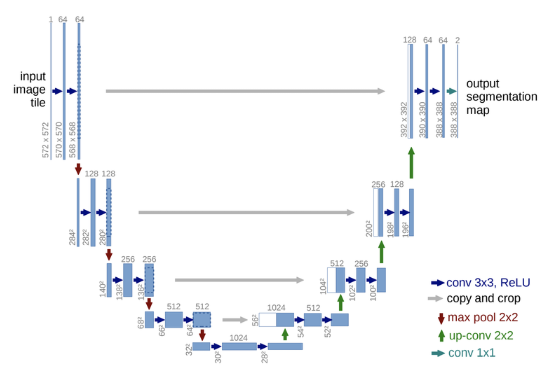

In [ ]:
def build_U_net_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # Encoder (Downsampling)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 모델 저장 경로
model_U_net_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/seg_model_unet.h5'

# 모델 정의 및 컴파일
model_U_net = build_U_net_model()
model_U_net.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')

# EarlyStopping 콜백 정의
earlystop = EarlyStopping(
    monitor='val_loss',     # 검증 손실을 기준으로
    patience=5,             # 5 epoch 연속 향상 없으면 종료
    restore_best_weights=True,  # 가장 좋은 가중치로 복원
    verbose=1
)

# 학습
history = model_U_net.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    verbose=1,
    callbacks=[earlystop]
)

# 학습 과정 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 모델 저장
model_U_net.save(model_U_net_path)


- build_U_net_plus_model
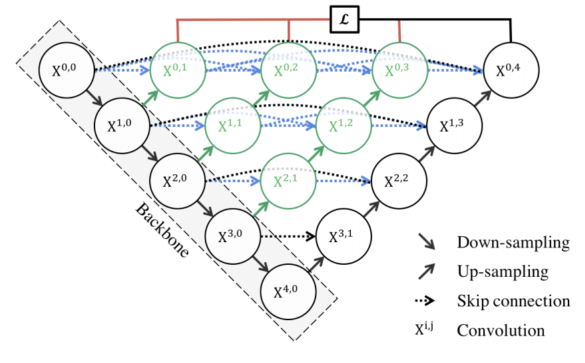

$$
\text{Dice} = \frac{2|A \cap B|}{|A| + |B|}
$$


In [ ]:

# Dice coefficient metric
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# U-Net++ building block
def conv_block(x, filters):
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

def build_U_net_plus(input_shape=(224, 224, 3), num_classes=1, use_transpose=False):
    inputs = Input(input_shape)

    # Encoder path
    x00 = conv_block(inputs, 64)
    p0 = MaxPooling2D((2, 2))(x00)

    x10 = conv_block(p0, 128)
    p1 = MaxPooling2D((2, 2))(x10)

    x20 = conv_block(p1, 256)
    p2 = MaxPooling2D((2, 2))(x20)

    x30 = conv_block(p2, 512)
    p3 = MaxPooling2D((2, 2))(x30)

    x40 = conv_block(p3, 1024)

    # Decoder path with nested dense skip connections
    def up_block(x, filters):
        return Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x) if use_transpose else UpSampling2D((2, 2))(x)

    x01 = conv_block(concatenate([x00, up_block(x10, 64)]), 64)
    x11 = conv_block(concatenate([x10, up_block(x20, 128)]), 128)
    x21 = conv_block(concatenate([x20, up_block(x30, 256)]), 256)
    x31 = conv_block(concatenate([x30, up_block(x40, 512)]), 512)

    x02 = conv_block(concatenate([x00, x01, up_block(x11, 64)]), 64)
    x12 = conv_block(concatenate([x10, x11, up_block(x21, 128)]), 128)
    x22 = conv_block(concatenate([x20, x21, up_block(x31, 256)]), 256)

    x03 = conv_block(concatenate([x00, x01, x02, up_block(x12, 64)]), 64)
    x13 = conv_block(concatenate([x10, x11, x12, up_block(x22, 128)]), 128)

    x04 = conv_block(concatenate([x00, x01, x02, x03, up_block(x13, 64)]), 64)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(x04)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
# U_net_plus_plus 학습하기 

# 배치사이즈 조정
BATCH_SIZE = 4 

train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
    batch_size=BATCH_SIZE
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False,
    batch_size=BATCH_SIZE
)


# 모델 저장 경로
model_U_net_plus_path = os.getenv('HOME') + '/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

# 모델 정의 및 컴파일
model_U_net_plus = build_U_net_plus()
model_U_net_plus.compile(
    optimizer=Adam(1e-4),
    loss=lambda y_true, y_pred: dice_loss(y_true, y_pred) + K.binary_crossentropy(y_true, y_pred),
    metrics=[dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)]
)

# EarlyStopping 콜백 설정
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# 모델 학습
history_U_net_plus = model_U_net_plus.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    verbose=1,
    callbacks=[earlystop]
)

# 모델 저장
model_U_net_plus.save(model_U_net_plus_path)

In [ ]:
print(history_U_net_plus.history.keys())


In [ ]:
#  시각화

# 1. Loss
plt.figure(figsize=(10, 5))
plt.plot(history_U_net_plus.history['loss'], label='Train Loss')
plt.plot(history_U_net_plus.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2. Loss + Dice + IoU 전체 시각화
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_U_net_plus.history['loss'], label='Train Loss')
plt.plot(history_U_net_plus.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Dice
plt.subplot(1, 3, 2)
plt.plot(history_U_net_plus.history['dice_coef'], label='Train Dice')
plt.plot(history_U_net_plus.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid()

# IoU
plt.subplot(1, 3, 3)
plt.plot(history_U_net_plus.history['mean_io_u'], label='Train IoU')
plt.plot(history_U_net_plus.history['val_mean_io_u'], label='Val IoU')
plt.title('IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

# Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
- 두 모델의 정량적, 정성적 성능을 비교
- 시각화, IoU 계산 등을 체계적으로 시도

In [ ]:
model_U_net = tf.keras.models.load_model(model_U_net_path )


In [ ]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model_U_net, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
i = 2    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model_U_net, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
def calculate_iou_score(target, prediction):

    # intersection을 구하는 코드를 작성해주세요.
    # 두 이미지에서 픽셀 값이 모두 1인 부분 (겹치는 부분)
    intersection = np.logical_and(target, prediction)

    # Union을 구하는 코드를 작성해주세요.
    # 두 이미지 중 하나라도 1인 부분 (합집합)
    union = np.logical_or(target, prediction)

    # iou 스코어를 구하되 결과값을 float로 만들어주세요!
    # IoU 계산 (float로 나눠야 함)
    iou_score = np.sum(intersection) / np.sum(union)
    print('IoU : %f' % iou_score )
    return iou_score


In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
for i in range(1, 6):  
    print(f" Processing image index: {i}")
    
    output, prediction, target = get_output(
        model_U_net,
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    iou = calculate_iou_score(target, prediction)
    print(f" IoU for image {i}: {iou:.4f}\n")


In [ ]:
for i in range(1, 6):  
    print(f" Processing image index: {i}")
    
    output, prediction, target = get_output(
        model_U_net_plus,
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    iou = calculate_iou_score(target, prediction)
    print(f" IoU for image {i}: {iou:.4f}\n")


In [ ]:
print(" IoU 비교 결과 (U-Net vs U-Net++)")
print("-" * 42)
print(f"{'Index':<8}{'U-Net':<15}{'U-Net++':<15}")
print("-" * 42)

for i in range(1, 10):
    # 공통 경로 문자열 만들기
    image_file = f'/image_2/00{str(i).zfill(4)}_10.png'
    label_file = f'/semantic/00{str(i).zfill(4)}_10.png'
    output_file_unet = f'./result_unet_{str(i).zfill(3)}.png'
    output_file_unetpp = f'./result_unetpp_{str(i).zfill(3)}.png'

    # U-Net 결과
    _, pred_unet, target = get_output(
        model_U_net,
        test_preproc,
        image_path=dir_path + image_file,
        output_path=dir_path + output_file_unet,
        label_path=dir_path + label_file
    )
    iou_unet = calculate_iou_score(target, pred_unet)

    # U-Net++ 결과
    _, pred_unetpp, _ = get_output(
        model_U_net_plus,
        test_preproc,
        image_path=dir_path + image_file,
        output_path=dir_path + output_file_unetpp,
        label_path=dir_path + label_file
    )
    iou_unetpp = calculate_iou_score(target, pred_unetpp)

    # 결과 출력
    print(f"{i:<8}{iou_unet:<15.4f}{iou_unetpp:<15.4f}")


| Index | U-Net IoU | U-Net++ IoU |
|-------|-----------|-------------|
| 1     | 0.8495    | 0.8522      |
| 2     | 0.7254    | 0.6204      | 
| 3     | 0.7435    | 0.6278      | 
| 4     | 0.7571    | 0.5128      | 
| 5     | 0.7319    | 0.5213      | 
| 6     | 0.6685    | 0.4684      | 
| 7     | 0.8664    | 0.7529      | 
| 8     | 0.8139    | 0.7646      | 
| 9     | 0.7769    | 0.7481      | 


- 현재 설정에서는 U-Net이 평균적으로 더 높은 IoU 성능을 보임.
- U-Net++의 Val_loss가 U-Net에 비해 더 높게 나온 이유에 대한 고민
    - Early Stopping 설정이 너무 일찍 학습을 멈춘 것은 아닌지 의심됨.
        - U-Net++가 더 복잡한 연산 구조를 가지기 때문에 학습이 더 오래걸리고 그만큼 epoch진행 횟수도 더 많을 것으로 예상했으나 U-Net보다 일찍 Early Stopping이 적용됨.
    - Deep Supervision 미적용으로 인한 성능 저하가 의심됨.
        - U-NET++구조가 더 좋은 성능을 보이는 핵심 이유 중 하나가 Deep Supervision인데 이것이 적용되지 않은 것이 문제일 수도 있겠음.
- Deep Supervision의 의미
    - 여러 출력층 결과의 손실을 구하여 보다 좋은 학습을 유도함.
        - 기울기 소실 문제 완화, 정규화 효과 등

In [ ]:
def build_U_net_plus_with_deep_suervision(input_shape=(224, 224, 3), num_classes=1, use_transpose=False, deep_supervision=False):
    inputs = Input(input_shape)

    # Encoder
    x00 = conv_block(inputs, 64)
    p0 = MaxPooling2D((2, 2))(x00)

    x10 = conv_block(p0, 128)
    p1 = MaxPooling2D((2, 2))(x10)

    x20 = conv_block(p1, 256)
    p2 = MaxPooling2D((2, 2))(x20)

    x30 = conv_block(p2, 512)
    p3 = MaxPooling2D((2, 2))(x30)

    x40 = conv_block(p3, 1024)

    # Decoder
    def up_block(x, filters):
        return Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x) if use_transpose else UpSampling2D((2, 2))(x)

    x01 = conv_block(concatenate([x00, up_block(x10, 64)]), 64)
    x11 = conv_block(concatenate([x10, up_block(x20, 128)]), 128)
    x21 = conv_block(concatenate([x20, up_block(x30, 256)]), 256)
    x31 = conv_block(concatenate([x30, up_block(x40, 512)]), 512)

    x02 = conv_block(concatenate([x00, x01, up_block(x11, 64)]), 64)
    x12 = conv_block(concatenate([x10, x11, up_block(x21, 128)]), 128)
    x22 = conv_block(concatenate([x20, x21, up_block(x31, 256)]), 256)

    x03 = conv_block(concatenate([x00, x01, x02, up_block(x12, 64)]), 64)
    x13 = conv_block(concatenate([x10, x11, x12, up_block(x22, 128)]), 128)

    x04 = conv_block(concatenate([x00, x01, x02, x03, up_block(x13, 64)]), 64)

    # Deep Supervision Outputs
    output_1 = Conv2D(num_classes, (1, 1), activation='sigmoid')(x01)
    output_2 = Conv2D(num_classes, (1, 1), activation='sigmoid')(x02)
    output_3 = Conv2D(num_classes, (1, 1), activation='sigmoid')(x03)
    output_4 = Conv2D(num_classes, (1, 1), activation='sigmoid')(x04)

    outputs = [output_1, output_2, output_3, output_4] if deep_supervision else [output_4]

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def total_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + tf.keras.losses.binary_crossentropy(y_true, y_pred)

model_U_net_path_plus_with_deep_suervision = os.getenv('HOME') + '/aiffel/semantic_segmentation/seg_model_unet_plus_with_deep_suervision.h5'

model_U_net_plus_with_deep_suervision = build_U_net_plus_with_deep_suervision(use_transpose=True, deep_supervision=True)
model_U_net_plus_with_deep_suervision.compile(
    optimizer=Adam(1e-4),
    loss=[total_loss] * 4,                # 4개의 출력 각각에 loss 적용
    loss_weights=[0.5, 0.7, 0.9, 1.0],     # 중요도 차이 반영
    metrics=[dice_coef]
)


In [ ]:
# 모델 학습
history_U_net_plus_with_deep_suervision = model_U_net_plus_with_deep_suervision.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    verbose=1,
    callbacks=[earlystop]
)



# 모델 저장
model_U_net_plus_with_deep_suervision.save(model_U_net_path_plus_with_deep_suervision)


In [ ]:
print(history_U_net_plus_with_deep_suervision.history.keys())

In [ ]:
#  시각화

# 1. Loss
plt.figure(figsize=(12, 6))
plt.title("Losses per Output")

plt.plot(history_U_net_plus_with_deep_suervision.history['loss'], label='Total Loss', color='black')
plt.plot(history_U_net_plus_with_deep_suervision.history['conv2d_185_loss'], label='Loss (x04)', color='red')
plt.plot(history_U_net_plus_with_deep_suervision.history['conv2d_184_loss'], label='Loss (x03)', color='orange')
plt.plot(history_U_net_plus_with_deep_suervision.history['conv2d_183_loss'], label='Loss (x02)', color='green')
plt.plot(history_U_net_plus_with_deep_suervision.history['conv2d_182_loss'], label='Loss (x01)', color='blue')

plt.plot(history_U_net_plus_with_deep_suervision.history['val_loss'], label='Val Total Loss', color='black', linestyle='--')
plt.plot(history_U_net_plus_with_deep_suervision.history['val_conv2d_185_loss'], label='Val Loss (x04)', color='red', linestyle='--')
plt.plot(history_U_net_plus_with_deep_suervision.history['val_conv2d_184_loss'], label='Val Loss (x03)', color='orange', linestyle='--')
plt.plot(history_U_net_plus_with_deep_suervision.history['val_conv2d_183_loss'], label='Val Loss (x02)', color='green', linestyle='--')
plt.plot(history_U_net_plus_with_deep_suervision.history['val_conv2d_182_loss'], label='Val Loss (x01)', color='blue', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2. Dice
plt.figure(figsize=(12, 6))
plt.title("Dice Coefficients per Output")

plt.plot(history_U_net_plus_with_deep_suervision.history['conv2d_185_dice_coef'], label='Dice (x04)', color='red')
plt.plot(history_U_net_plus_with_deep_suervision.history['conv2d_184_dice_coef'], label='Dice (x03)', color='orange')
plt.plot(history_U_net_plus_with_deep_suervision.history['conv2d_183_dice_coef'], label='Dice (x02)', color='green')
plt.plot(history_U_net_plus_with_deep_suervision.history['conv2d_182_dice_coef'], label='Dice (x01)', color='blue')

plt.plot(history_U_net_plus_with_deep_suervision.history['val_conv2d_185_dice_coef'], label='Val Dice (x04)', color='red', linestyle='--')
plt.plot(history_U_net_plus_with_deep_suervision.history['val_conv2d_184_dice_coef'], label='Val Dice (x03)', color='orange', linestyle='--')
plt.plot(history_U_net_plus_with_deep_suervision.history['val_conv2d_183_dice_coef'], label='Val Dice (x02)', color='green', linestyle='--')
plt.plot(history_U_net_plus_with_deep_suervision.history['val_conv2d_182_dice_coef'], label='Val Dice (x01)', color='blue', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:

print(" IoU 비교 결과 (U-Net vs U-Net++ vs U-Net++(DeepSupervision))")
print("-" * 60)
print(f"{'Index':<8}{'U-Net':<15}{'U-Net++':<15}{'U-Net++ DS':<15}")
print("-" * 60)

for i in range(1, 10):
    # 공통 경로 설정
    image_file = f'/image_2/00{str(i).zfill(4)}_10.png'
    label_file = f'/semantic/00{str(i).zfill(4)}_10.png'
    output_file_unet = f'/result_unet_{str(i).zfill(3)}.png'
    output_file_unetpp = f'/result_unetpp_{str(i).zfill(3)}.png'
    output_file_unetpp_ds = f'/result_unetpp_ds_{str(i).zfill(3)}.png'

    # U-Net 결과
    _, pred_unet, target = get_output(
        model_U_net,
        test_preproc,
        image_path=dir_path + image_file,
        output_path=dir_path + output_file_unet,
        label_path=dir_path + label_file
    )
    iou_unet = calculate_iou_score(target, pred_unet)

    # U-Net++ 결과
    _, pred_unetpp, _ = get_output(
        model_U_net_plus,
        test_preproc,
        image_path=dir_path + image_file,
        output_path=dir_path + output_file_unetpp,
        label_path=dir_path + label_file
    )
    iou_unetpp = calculate_iou_score(target, pred_unetpp)

    # U-Net++ with Deep Supervision 결과 (마지막 출력만 사용)
    input_image = imread(dir_path + image_file)
    processed = test_preproc(image=input_image)["image"]
    model_input = np.expand_dims(processed / 255.0, axis=0)
    
    output_ds = model_U_net_plus_with_deep_suervision.predict(model_input)

    # 마지막 출력만 사용
    if isinstance(output_ds, list):
        pred_unetpp_ds = (output_ds[-1][0] > 0.5).astype(np.uint8)
    else:
        pred_unetpp_ds = (output_ds[0] > 0.5).astype(np.uint8)

    # GT와 예측 크기 맞추기
    target_ds = imread(dir_path + label_file)
    target_resized = resize(target_ds, pred_unetpp_ds.shape, order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)
    pred_squeezed = np.squeeze(pred_unetpp_ds)

    # IoU 계산
    iou_unetpp_ds = calculate_iou_score(target_resized, pred_squeezed)

    # 결과 출력
    print(f"{i:<8}{iou_unet:<15.4f}{iou_unetpp:<15.4f}{iou_unetpp_ds:<15.4f}")



###  IoU 비교 결과 (U-Net vs U-Net++ vs U-Net++ with Deep Supervision)

| Index | U-Net   | U-Net++ | U-Net++ DS |
|-------|--------:|--------:|-----------:|
| 1     | 0.8495  | 0.8522  | 0.2813     |
| 2     | 0.7254  | 0.6204  | 0.3218     |
| 3     | 0.7435  | 0.6278  | 0.1977     |
| 4     | 0.7571  | 0.5128  | 0.1873     |
| 5     | 0.7319  | 0.5213  | 0.1756     |
| 6     | 0.6685  | 0.4684  | 0.1359     |
| 7     | 0.8664  | 0.7529  | 0.3127     |
| 8     | 0.8139  | 0.7646  | 0.2625     |
| 9     | 0.7769  | 0.7481  | 0.3442     |


## 객체의 경계(Edge) 부분을 얼마나 잘 맞췄는지 평가할 수 있는 metric

### 왜 일반 metric은 부족할까?

일반적으로 segmentation에서는 이런 metric을 많이 씀:

- **IoU (Intersection over Union)**
- **Dice coefficient**
- **Pixel accuracy**

이런 것들은 전체 픽셀 단위로 **겹치는 정도**를 평가해. 그런데 이 방식엔 단점 :

 경계(Edge)가 조금만 어긋나도 전체 IoU는 크게 떨어지지 않을 수 있음.

 그래서 **경계 근처만 집중해서 평가하는 metric이 따로 필요**

| 이름 | 설명 | 장점 | 단점 |
| --- | --- | --- | --- |
| **Boundary IoU (BIoU)** | 경계에서 일정 거리 이내만 따로 비교해서 IoU 계산 | 경계 예측 잘했는지 확인 | 구현 복잡도 있음 |
| **Hausdorff Distance** | 예측 경계와 GT 경계 사이의 **가장 먼 거리** 측정 | 경계의 오차 민감하게 탐지 | 노이즈에 민감 |
| **Boundary F1 Score (BF Score)** | 경계선에서 일정 거리 내 일치 여부로 **F1 점수** 계산 | Precision/Recall 같이 비교 | 경계가 애매할 땐 애매하게 측정됨 |
| **Chamfer Distance** | 경계 포인트들의 평균 거리 계산 | 매끄러운 경계 평가에 적합 | 실시간에 느림 |


- **간단하게 경계 평가하고 싶다 → `Boundary F1 Score`**
- **정확한 거리 기반 경계 평가 원한다 → `Hausdorff Distance`**

# 회고
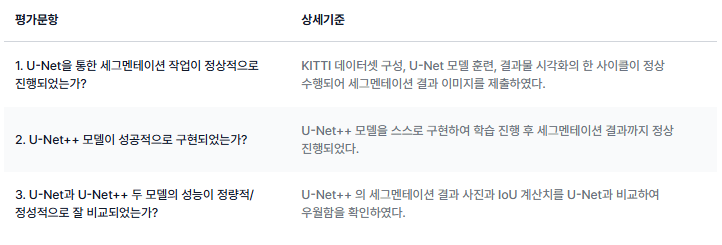

1. 넵!
2. 넵!
3. 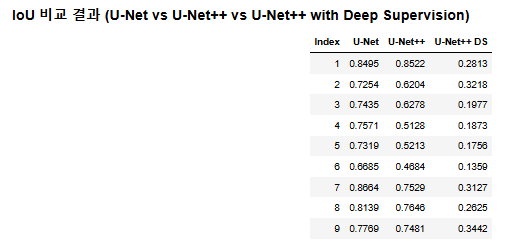